In [1]:
from datasets.load import load_images, load_annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots

## Preprocessing configuration

In [3]:
SIZE = 128
NUM_NEG_SAMPLES = 500
TRAIN_TEST_SPLIT = .8

assert TRAIN_TEST_SPLIT > 0 and TRAIN_TEST_SPLIT < 1

## Save positive samples to disk

In [ ]:
# read training dataset
classes = load_annotations('train', 'datasets', size=SIZE)

In [ ]:
for cl in classes.values():
    for idx, sample in enumerate(cl[:16]):
        ax = plt.subplot(4,4,idx +1)
        plt.imshow(sample)
        plt.title('sample {}, size: {}'.format(idx, sample.shape))
    plt.show()

In [ ]:
# write classes to .pkl files
import pickle
import os

def save_classes(classes, p):
    for name, imgs in classes.items():
        path = os.path.join(p, '{}.pkl'.format(name))
        with open(path, 'wb') as f:
            pickle.dump(imgs, f)
        print('wrote class: {} with {} samples to {}'.format(name, len(imgs), path)) 

        
save_classes(classes, 'cache/training')
classes = None

In [ ]:
# read testing dataset
classes = load_annotations('val', 'datasets', size=SIZE)

In [ ]:
save_classes(classes, 'cache/testing')
classes = None

## Generate negative samples

In [4]:
samples = load_images('train', 'datasets')

In [5]:
import pickle
import os
import cv2

def bbx_iou(bbx1, bbx2):
    assert bbx1[0] < bbx1[2]
    assert bbx1[1] < bbx1[3]
    assert bbx2[0] < bbx2[2]
    assert bbx2[1] < bbx2[3]
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bbx1[0], bbx2[0])
    y_top = max(bbx1[1], bbx2[1])
    x_right = min(bbx1[2], bbx2[2])
    y_bottom = min(bbx[3], bbx2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bbx1_area = (bbx1[2] - bbx1[0]) * (bbx1[3] - bbx1[1])
    bbx2_area = (bbx2[2] - bbx2[0]) * (bbx2[3] - bbx2[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bbx1_area + bbx2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
    
    
neg_samples = []
for sample in samples:
    sy, sx = sample['img'].shape[:2]
    for scale in np.random.uniform(low=0.1, high=1, size=5):
        if sy*scale - SIZE <= 5 or sx*scale - SIZE <= 5:
            continue
        
        r = cv2.resize(sample['img'], dsize=(int(sx*scale), int(sy*scale)), interpolation=cv2.INTER_NEAREST)
        views = zip(np.random.randint(low=0, high=r.shape[0] - SIZE, size=NUM_NEG_SAMPLES//(len(samples) * 5)),
                   np.random.randint(low=0, high=r.shape[1] - SIZE, size=NUM_NEG_SAMPLES//(len(samples) * 5)))
        for v in views:
            # ensure there is no overlap between bounding boxes and negative sample
            bbx = [v[1], v[0], v[1] + SIZE, v[0] + SIZE]
            if 0.1 > np.max([bbx_iou(bbx, b) for cl in sample['classes'] for b in cl['bounds']]):
                neg_samples.append(r[v[0]:v[0] + SIZE, v[1]:v[1] + SIZE])

# Free samples
samples = None

neg_samples = np.array(neg_samples)
np.random.shuffle(neg_samples)
split = int(TRAIN_TEST_SPLIT * neg_samples.shape[0])

neg_train, neg_test = neg_samples[:split,:], neg_samples[split:, :]


In [6]:
with open('cache/training/neg_samples.pkl', 'wb') as f:
    pickle.dump(neg_train, f)
with open('cache/testing/neg_samples.pkl', 'wb') as f:
    pickle.dump(neg_test, f)

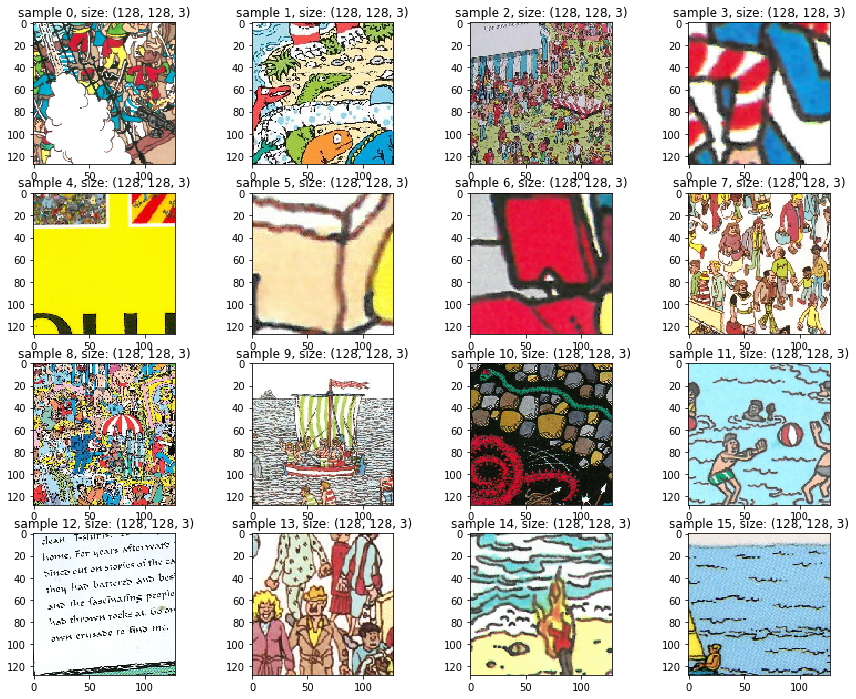

244


In [7]:
for idx, sample in enumerate(neg_train[:16]):
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(sample)
    plt.title('sample {}, size: {}'.format(idx, sample.shape))

plt.show()
print(len(neg_train))